In [1]:
import torch
from torch import nn
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


In [2]:
def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')

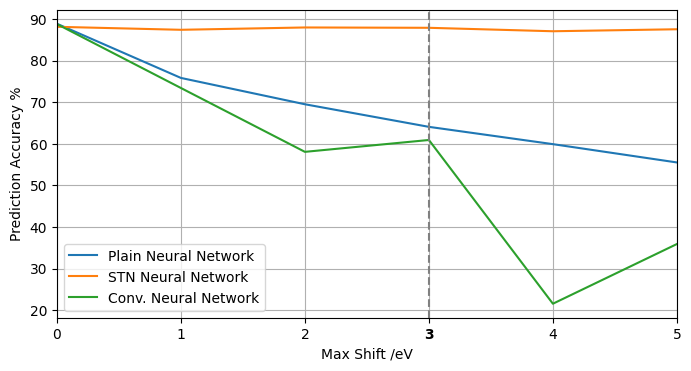

In [3]:
model_names = ['plain_classifier', 'STN', 'conv_classifier' ]
accuracies = {}

shift_values = [0, 1, 2, 3, 4, 5] 

for model in model_names:
    report_dir = Path(f'../reports/final_results/{model}_results')
    summary_df = pd.read_csv(report_dir / 'all_results_summary.csv')
    accuracy_array = summary_df['aggregate_val_accuracy'].values
    accuracies[model] = accuracy_array


label_names = ['Plain Neural Network', 'STN Neural Network','Conv. Neural Network']  # Updated labels
plt.figure(figsize=(8, 4), facecolor='white')
for model, accuracy in zip(label_names, accuracies.items()): 
    plt.plot(shift_values, accuracy[1], label=model)  # Use accuracy[1] to get the accuracy value
plt.axvline(x=3, color='grey', linestyle='--')  # Dotted line

# Customize x-tick labels
ticks = plt.xticks()[0]  # Get current x-tick positions
labels = [str(int(tick)) for tick in ticks]  # Convert ticks to string
labels[4] = r'$\mathbf{3}$'  # Make the label for 3 bold

plt.xticks(ticks, labels)  # Set the new tick labels

plt.xlabel('Max Shift /eV')
plt.ylabel('Prediction Accuracy %')
plt.xlim(0,5)
plt.grid(True)
plt.legend()
plt.savefig('classifier_comparison.png', dpi=300, bbox_inches='tight')

plt.show()


In [29]:
model_name = 'STN'
report_dir = Path(f'../reports/final_results/{model_name}_results')
if report_dir.exists():
    print(f"Directory {report_dir} exists.")
else:
    print(f"Directory {report_dir} does not exist.")

Directory ../reports/final_results/STN_results exists.


In [30]:
conf_matrix_path = report_dir / 'shift_3eV/confusion_matrices.npy'
conf_matrix = np.load(conf_matrix_path)
print(conf_matrix)


[[[ 9089    24]
  [  123   764]]

 [[10000     0]
  [    0     0]]

 [[ 5943     6]
  [  139  3912]]

 [[ 9823     0]
  [   12   165]]

 [[ 8652     1]
  [   36  1311]]

 [[ 9809     0]
  [   11   180]]

 [[ 9182    36]
  [  127   655]]

 [[ 8672     6]
  [   49  1273]]

 [[ 7143    41]
  [  156  2660]]

 [[ 9104     0]
  [   12   884]]

 [[ 9256     1]
  [   15   728]]

 [[10000     0]
  [    0     0]]

 [[10000     0]
  [    0     0]]

 [[10000     0]
  [    0     0]]

 [[10000     0]
  [    0     0]]

 [[ 9812     2]
  [   14   172]]

 [[ 9425     0]
  [   40   535]]

 [[ 9431     1]
  [   48   520]]

 [[ 6016   131]
  [  172  3681]]

 [[ 9591     6]
  [   38   365]]

 [[ 8519     5]
  [   34  1442]]

 [[10000     0]
  [    0     0]]

 [[ 9808     0]
  [    3   189]]

 [[ 9643     0]
  [   11   346]]

 [[ 9803     2]
  [   38   157]]

 [[ 9593     2]
  [   24   381]]

 [[10000     0]
  [    0     0]]

 [[ 9793     6]
  [   18   183]]

 [[ 9787     0]
  [    4   209]]

 [[ 9585     0

In [26]:
shift_values = [3]  # Same as during training

# 1. Load the summary results
summary_df = pd.read_csv(report_dir / 'all_results_summary.csv')
print("Summary of all experiments:")
print(summary_df.head())

# 2. Initialize containers for all data
all_metrics = []
all_confusion_mats = []
all_norm_mats = []

# 3. Load data for each shift value
for shift in shift_values:
    shift_dir = report_dir / f'shift_{shift}eV'
    
    # Load metrics
    metrics = pd.read_csv(shift_dir / 'class_metrics.csv')
    metrics['shift'] = shift  # Add shift column for identification
    all_metrics.append(metrics)
    
    # Load training curves
    curves = pd.read_csv(shift_dir / 'training_curves.csv')
    
    stable_epoch = 10 
    mask = curves['epoch'] >= stable_epoch
    # Calculate max y from the stable region
    y_max = max(curves['train_loss'][mask])*1.1
    y_min = min(curves['train_loss'][mask])*0.95
    plt.style.use('default')  # Reset to default style
    plt.figure(facecolor='white')
    plt.plot(curves['epoch'], curves['train_loss'], label='Train Loss')
    plt.plot(curves['epoch'], curves['test_loss'], label='Test Loss')
    plt.title(f'Training Curves - Shift {shift}eV')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(stable_epoch,)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.savefig(shift_dir / 'training_curves_plot.png')
    plt.close()

    # Load confusion matrices
    class_cms = np.load(shift_dir / 'confusion_matrices.npy')
    norm_cms = np.load(shift_dir / 'normalized_confusion_matrices.npy')
    all_confusion_mats.append(class_cms)
    all_norm_mats.append(norm_cms)

    valid_class_cms = [cm for cm in class_cms if cm[1].sum() > 0]

    aggregate_cm = np.sum(valid_class_cms[:-1], axis=0)

    # Normalize by true label (row-wise)
    normalized_aggregate = aggregate_cm.astype('float') / aggregate_cm.sum(axis=1)[:, np.newaxis] * 100

    # Format percentages with "%" symbol
    annotations = np.vectorize(lambda x: f"{x:.1f}%")(normalized_aggregate)

    # Create figure
    fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

    # Plot heatmap without color bar
    sns.heatmap(
        normalized_aggregate,
        annot=annotations,
        fmt='',
        cmap="Blues",
        linewidths=1,
        linecolor='black',
        cbar=False,
        ax=ax,
        annot_kws={'fontsize': 10} 
    )

    # Customize tick labels
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'], rotation=90)
    plt.savefig('plain_NN_confusion_matrix.png', dpi=300,bbox_inches='tight')
    # Layout & Save
    plt.tight_layout()
    plt.savefig(shift_dir / 'aggregate_confusion_matrix_plot.png', bbox_inches='tight', transparent=True)
    plt.savefig(shift_dir / 'aggregate_confusion_matrix_plot.pdf')  # Publication-quality
    plt.close(fig)

# Combine all metrics into one dataframe
combined_metrics = pd.concat(all_metrics)


Summary of all experiments:
   shift_value  final_train_loss  final_test_loss  final_train_acc  \
0            0          0.014045         0.013636          86.2050   
1            1          0.015329         0.014573          84.7725   
2            2          0.014585         0.014232          85.4300   
3            3          0.014442         0.014681          85.5525   
4            4          0.014637         0.015421          85.2475   

   final_test_acc  aggregate_val_accuracy  mean_precision  mean_recall  \
0           88.15                   88.15        0.795269     0.759325   
1           87.43                   87.43        0.794353     0.755336   
2           87.99                   87.99        0.795379     0.756326   
3           87.91                   87.91        0.793674     0.757135   
4           87.08                   87.08        0.792233     0.753783   

    mean_f1  
0  0.776633  
1  0.773979  
2  0.774979  
3  0.774631  
4  0.772147  


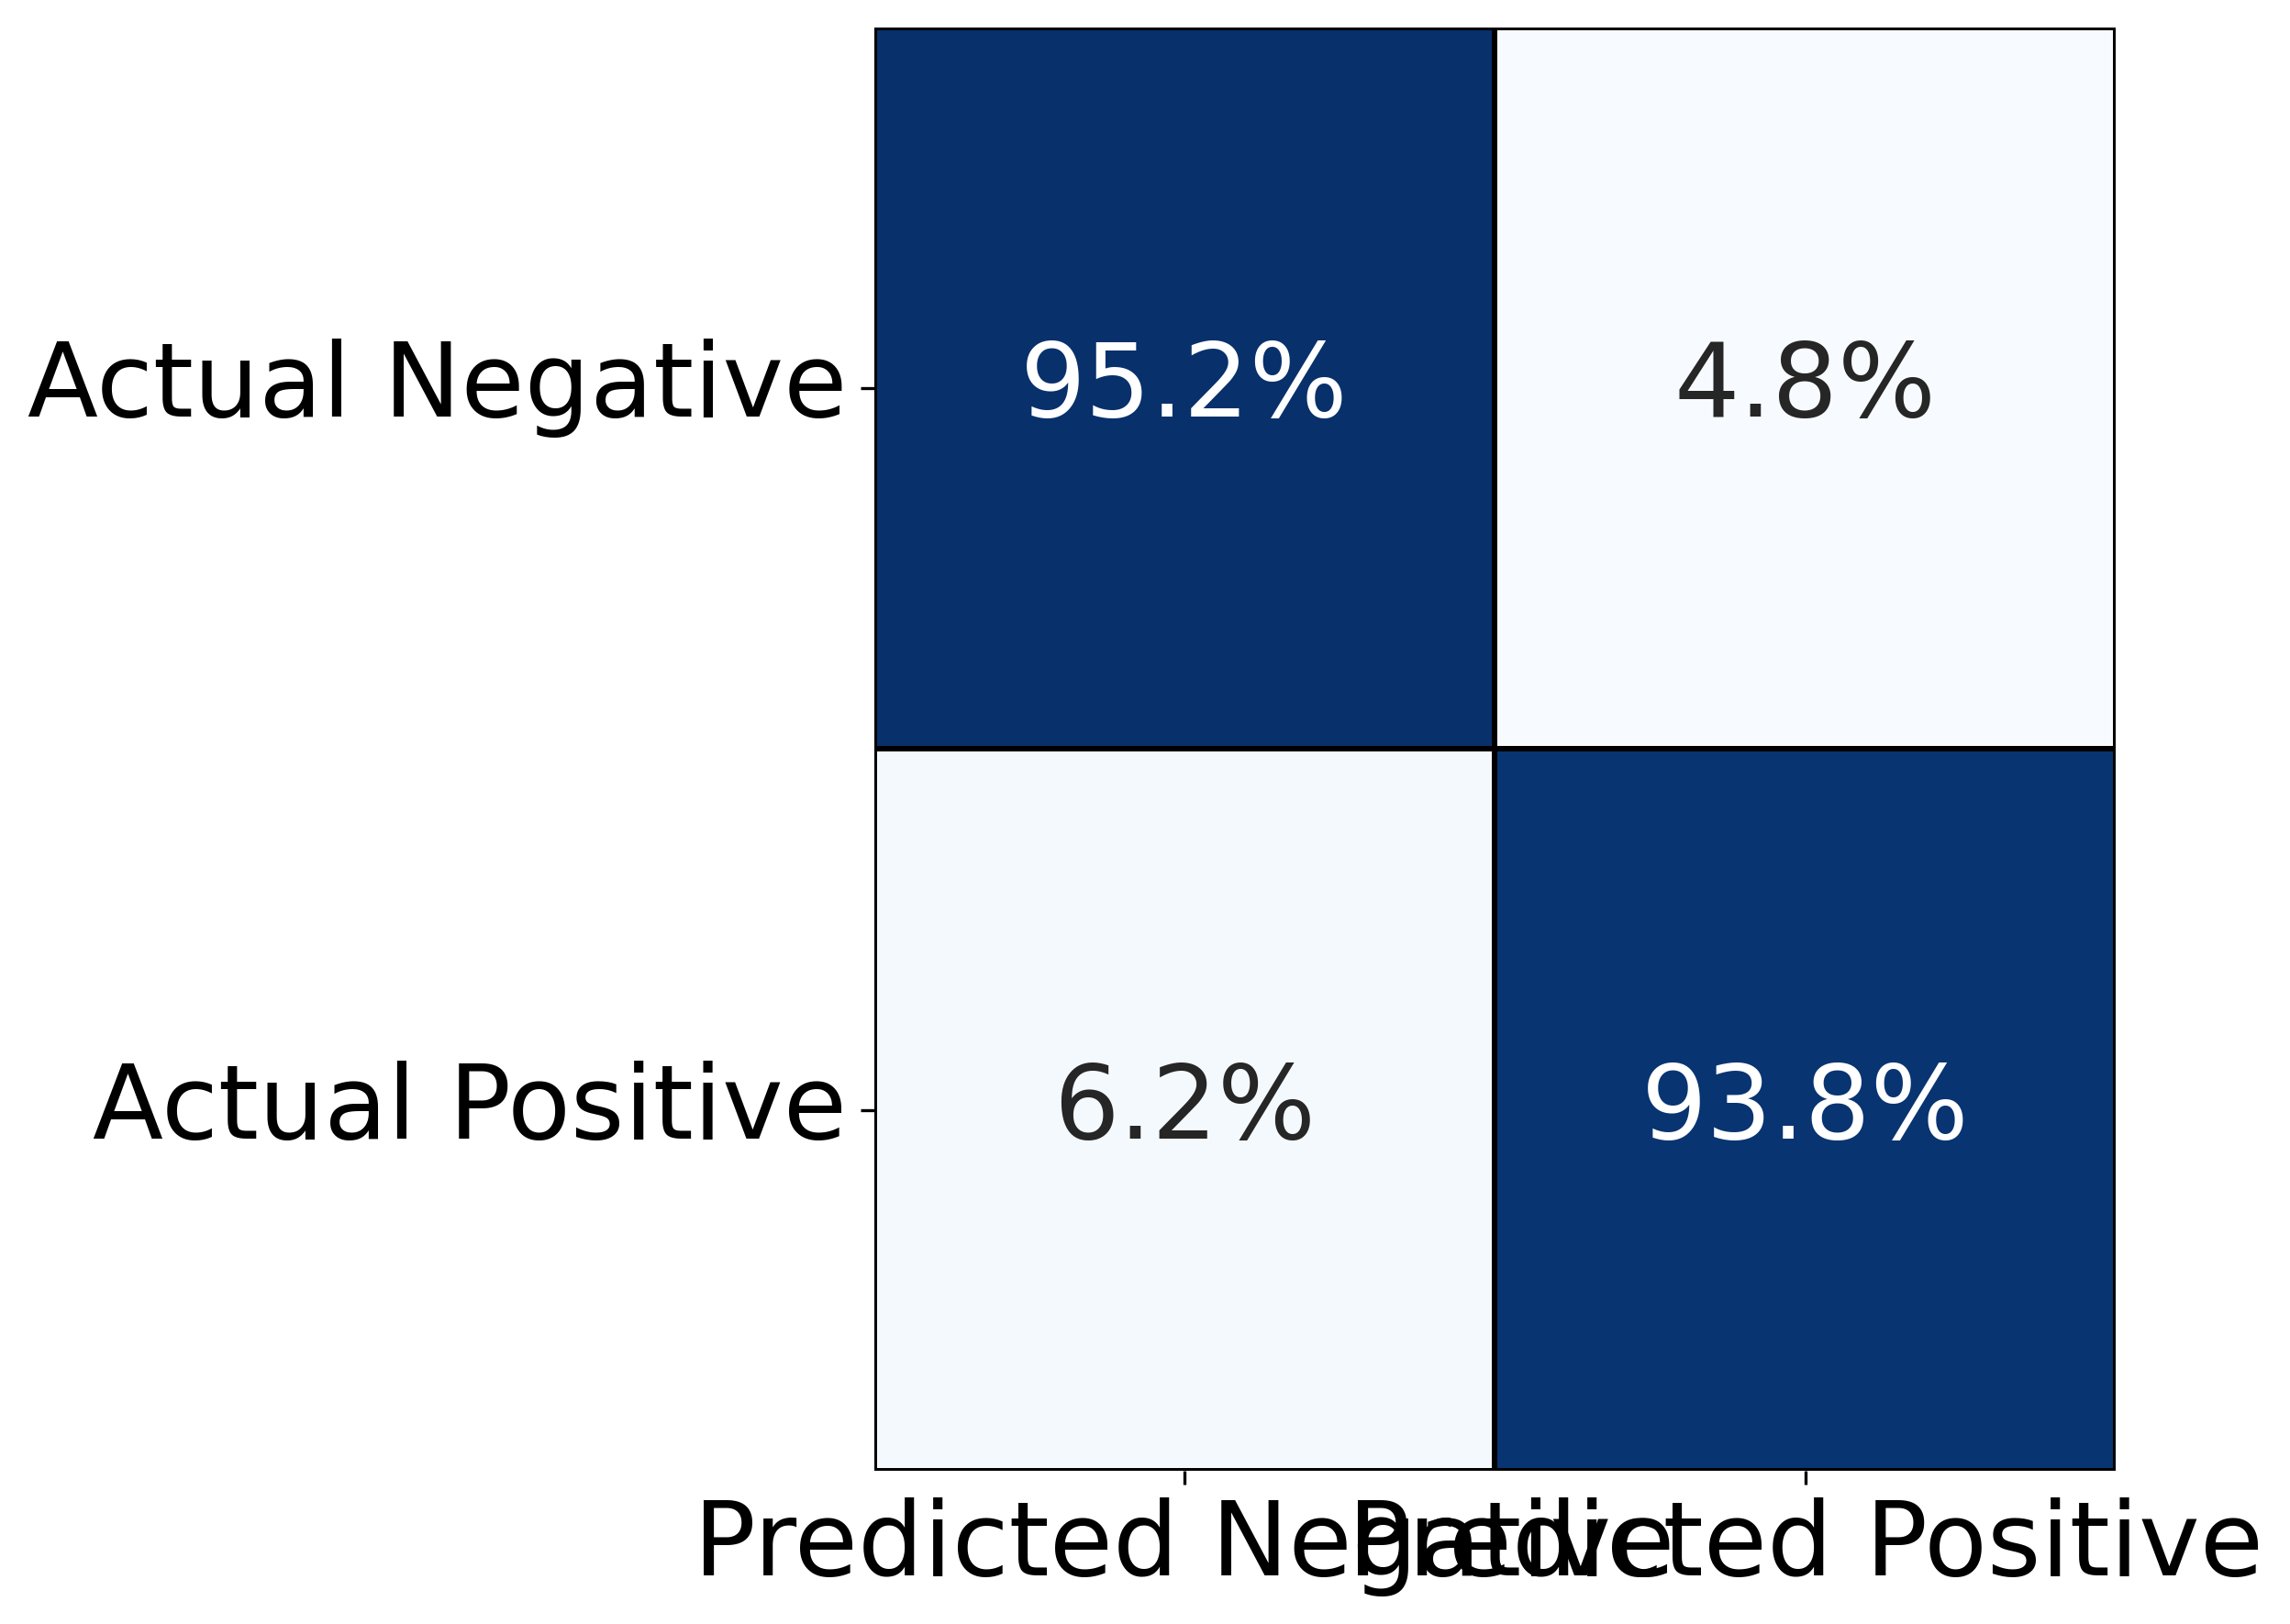


Combined Metrics:
  metric  value  shift
0    acc    0.9      3


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path # Assuming report_dir is a Path object

# Define report_dir (replace with your actual path)
report_dir = Path('.') # Example: current directory

shift_values = [3]  # Same as during training

# 1. Load the summary results
# summary_df = pd.read_csv(report_dir / 'all_results_summary.csv')
# print("Summary of all experiments:")
# print(summary_df.head())

# 2. Initialize containers for all data
all_metrics = []
all_confusion_mats = []
all_norm_mats = []

# --- Start of modified loop section ---

# 3. Load data for each shift value
for shift in shift_values:
    # Create dummy data if directories don't exist for demonstration
    shift_dir = report_dir / f'shift_{shift}eV'
    shift_dir.mkdir(exist_ok=True) # Ensure directory exist

    # Load metrics
    metrics = pd.read_csv(shift_dir / 'class_metrics.csv')
    metrics['shift'] = shift  # Add shift column for identification
    all_metrics.append(metrics)

    # Load training curves
    curves = pd.read_csv(shift_dir / 'training_curves.csv')

    stable_epoch = 10
    mask = curves['epoch'] >= stable_epoch
    # Calculate max y from the stable region (handle potential empty mask)
    if mask.any():
         y_max = max(curves['train_loss'][mask]) * 1.1
         y_min = min(curves['train_loss'][mask]) * 0.95
    else:
         y_max = max(curves['train_loss']) * 1.1
         y_min = min(curves['train_loss']) * 0.95

    plt.style.use('default')  # Reset to default style
    plt.figure(facecolor='white')
    plt.plot(curves['epoch'], curves['train_loss'], label='Train Loss')
    plt.plot(curves['epoch'], curves['test_loss'], label='Test Loss')
    plt.title(f'Training Curves - Shift {shift}eV')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(stable_epoch,)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.savefig(shift_dir / 'training_curves_plot.png')
    plt.close()

    # Load confusion matrices
    class_cms = np.load(shift_dir / 'confusion_matrices.npy')
    norm_cms = np.load(shift_dir / 'normalized_confusion_matrices.npy')
    all_confusion_mats.append(class_cms)
    all_norm_mats.append(norm_cms)

    plt.rcParams['font.size']
    # --- Aggregate Confusion Matrix Plotting ---
    # Check if class_cms is not empty before processing
    if len(class_cms) > 0:
        valid_class_cms = [cm for cm in class_cms if cm.shape == (2, 2) and cm[1].sum() > 0] # Ensure shape is 2x2

        # Check if valid_class_cms is not empty before summing
        if len(valid_class_cms) > 0:
            # Assuming the last one might be an aggregate already or different format
            aggregate_cm = np.sum(valid_class_cms[:-1] if len(valid_class_cms) > 1 else valid_class_cms, axis=0)

            # Ensure aggregate_cm is not empty and denominators are not zero before normalizing
            if aggregate_cm.shape == (2, 2) and np.all(aggregate_cm.sum(axis=1) > 0):
                # Normalize by true label (row-wise)
                normalized_aggregate = aggregate_cm.astype('float') / aggregate_cm.sum(axis=1)[:, np.newaxis] * 100

                # Format percentages with "%" symbol
                annotations = np.vectorize(lambda x: f"{x:.1f}%")(normalized_aggregate)

                # --- Font Size Adjustment ---
                # Get default font size and add 2
                default_fontsize = 25
                target_annot_fontsize = default_fontsize + 2
                target_tick_fontsize = default_fontsize + 2
                # --- End Font Size Adjustment ---


                # Create figure
                fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

                # Plot heatmap without color bar, applying font size changes
                sns.heatmap(
                    normalized_aggregate,
                    annot=annotations,
                    annot_kws={'size': target_annot_fontsize}, # Set annotation font size
                    fmt='',
                    cmap="Blues",
                    linewidths=1,
                    linecolor='black',
                    cbar=False,
                    ax=ax
                )

                # Customize tick labels
                ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
                ax.set_yticklabels(['Actual Negative', 'Actual Positive'], rotation=0)

                # Apply font size changes to tick labels
                ax.tick_params(axis='x', labelsize=target_tick_fontsize)
                ax.tick_params(axis='y', labelsize=target_tick_fontsize)
                # Layout & Save
                plt.tight_layout()
                plt.show()
                '''
                plt.savefig(shift_dir / 'aggregate_confusion_matrix_plot.png', bbox_inches='tight', transparent=True)
                plt.savefig(shift_dir / 'aggregate_confusion_matrix_plot.pdf')  # Publication-quality
                plt.close(fig)
                '''
            else:
                print(f"Skipping aggregate CM plot for shift {shift}: Invalid aggregate_cm or zero sum rows.")
        else:
            print(f"Skipping aggregate CM plot for shift {shift}: No valid individual confusion matrices found.")
    else:
        print(f"Skipping aggregate CM plot for shift {shift}: No confusion matrices loaded.")


# Combine all metrics into one dataframe
if all_metrics: # Check if list is not empty
    combined_metrics = pd.concat(all_metrics)
    print("\nCombined Metrics:")
    print(combined_metrics)
else:
    print("\nNo metrics were loaded.")

# --- End of modified loop section ---

In [27]:
import numpy as np
from pathlib import Path
import pandas as pd

# Load saved data
model_name = 'conv_classifier'
shift_value = 3  # Or loop through all shifts
shift_dir = Path(f"../reports/final_results/{model_name}_results/shift_{shift_value}eV")
class_cms = np.load(shift_dir / "confusion_matrices.npy")  # Shape: [n_classes, 2, 2]

# Calculate sensitivity for each class
sensitivity_values = []
for i, cm in enumerate(class_cms):
    if cm.shape == (2, 2):  # Standard 2x2 matrix
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    else:  # Degenerate case (always TN)
        sensitivity = 0.0  # Or np.nan if you prefer
    sensitivity_values.append(sensitivity)

avg_sensitivity = np.nanmean(sensitivity_values)
print(avg_sensitivity)

# Create and print table
metrics_df = pd.DataFrame({
    'Index': [i for i in range(len(class_cms))],
    'FG' : FG_list,
    'Sensitivity': sensitivity_values
})

metrics_df_sorted= metrics_df.sort_values(by='Sensitivity')


# Format for clean printing
pd.set_option('display.float_format', '{:.3f}'.format)
print(metrics_df_sorted.to_string(index=False))

0.7479937673649877
 Index                  FG  Sensitivity
    24             epoxide        0.128
    27           anhydride        0.239
     6 alcohol (aliphatic)        0.434
     3         naphthalene        0.452
    19     carboxylic acid        0.499
    35            siloxane        0.550
     5  alcohol (aromatic)        0.618
    17    ester (aromatic)        0.634
    16  ketone (aliphatic)        0.635
     0              alkene        0.639
    15   ketone (aromatic)        0.645
     8   ether (aliphatic)        0.756
    25               imide        0.765
     4               amine        0.778
     7    ether (aromatic)        0.821
    37             phenoxy        0.824
    36         phosphazene        0.835
    23             nitrile        0.843
    18   ester (aliphatic)        0.852
    20               amide        0.854
     2        benzene ring        0.870
    38            pyridine        0.872
    29             sulfide        0.887
    22             ni

<Figure size 1000x600 with 0 Axes>

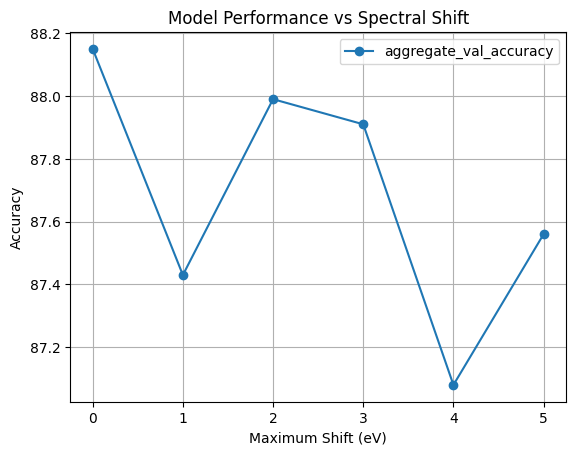

In [111]:


# Plot mean F1 score vs shift
plt.figure(figsize=(10, 6))
summary_df.plot(x='shift_value', y='aggregate_val_accuracy', marker='o')
plt.title('Model Performance vs Spectral Shift')
plt.xlabel('Maximum Shift (eV)')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()
